In [ ]:
import numpy as np
import re
import pandas as pd
import os
import sys
import json
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
notebook_path = os.path.abspath("")
sys.path.append(os.path.join(notebook_path, '..'))
from model_custom_pca.rpca import Robust_PCA
from model_custom_pca.rpca_augmented import Robust_PCA_augmented

# Datasets building

## Image Datasets

In [2]:
def read_pgm(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    return np.frombuffer(buffer,
                         dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                         count=int(width)*int(height),
                         offset=len(header)
                         ).reshape((int(height), int(width)))

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Bekka\AppData\Local\Temp\ipykernel_4540\2574217242.py:5: SyntaxWarning: invalid escape sequence '\s'
  b"(^P5\s(?:\s*#.*[\r\n])*"
C:\Users\Bekka\AppData\Local\Temp\ipykernel_4540\2574217242.py:6: SyntaxWarning: invalid escape sequence '\d'
  b"(\d+)\s(?:\s*#.*[\r\n])*"
C:\Users\Bekka\AppData\Local\Temp\ipykernel_4540\2574217242.py:7: SyntaxWarning: invalid escape sequence '\d'
  b"(\d+)\s(?:\s*#.*[\r\n])*"
C:\Users\Bekka\AppData\Local\Temp\ipykernel_4540\2574217242.py:8: SyntaxWarning: invalid escape sequence '\d'
  b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()


In [3]:
def load_images(base_path, num_people, num_images_per_person):
    X = []
    y = []
    for person_id in range(1, num_people+1):
        folder = os.path.join(base_path, f"s{person_id}")
        for image_id in range(1, num_images_per_person+1):
            image_path = os.path.join(folder, f"{image_id}.pgm")
            image = read_pgm(image_path)
            image = (image - np.mean(image)) / np.std(image)
            X.append(image.flatten())
            y.append(person_id - 1)
    return np.array(X), np.array(y)

(400, 10304)


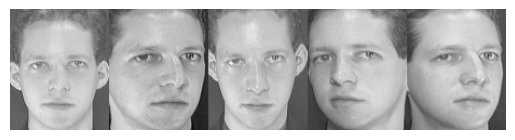

In [4]:
base_path = "C:\\MVA\\1er Semestre\\G Data Analysis\\RPCA\\att_faces\\"
num_people_cmu = 40
num_images_per_person_cmu = 10
X_cmu, y_cmu = load_images(base_path, num_people_cmu, num_images_per_person_cmu)
print(X_cmu.shape)
#show 5 images next to each other
#deactivate the axis
plt.axis('off')
plt.imshow(np.concatenate(X_cmu[:5].reshape(-1, 112, 92), axis=1), cmap='gray')

In [5]:
def load_corrupted_cmu(path, num_people, num_images_per_person):
    X = []
    y = []
    for i in range(num_people):
        for j in range(num_images_per_person):
            img_number = i * num_images_per_person + j
            image_path = os.path.join(path, f"Cyprien_{img_number}.jpg")
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = (image - np.mean(image)) / np.std(image)
            X.append(image.flatten())
            y.append(i)


    return np.array(X), np.array(y)

(400, 10304)


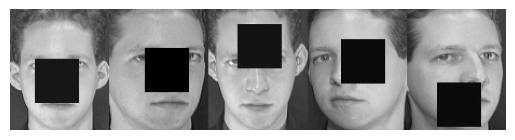

In [6]:
corrupted_path = "C:\\MVA\\1er Semestre\\G Data Analysis\\RPCA\\Robust-PCA-Augmented\\Corrupted_Datasets\\full_occluded_CMU"
annotations_cmu = json.load(open(os.path.join(corrupted_path, "annotation.json")))
num_images_per_person_corrupted = 10
num_people_corrupted = 40
X_cmu_corrupted, y_cmu_corrupted = load_corrupted_cmu(corrupted_path, num_people_corrupted, num_images_per_person_corrupted)
print(X_cmu_corrupted.shape)
plt.axis('off')
plt.imshow(np.concatenate(X_cmu_corrupted[:5].reshape(-1, 112, 92), axis=1), cmap='gray')

## Non Image Dataset

In [7]:
# Reading the UCI HAR Dataset
HAR_path = "C:\\MVA\\1er Semestre\\G Data Analysis\\RPCA\\HAR"
df_har = pd.read_csv(os.path.join(HAR_path, "train.csv"))
y_har = df_har["Activity"]
y_har = pd.Categorical(y_har).codes
num_col = df_har.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
scaler.fit(df_har[num_col])
df_har[num_col] = scaler.transform(df_har[num_col])
df_har = pd.DataFrame(df_har, columns=num_col)
print(df_har.shape)
print(len(np.unique(y_har)))
df_har.head()


(7352, 562)
6


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.200642,-0.063683,-0.419628,-0.868814,-0.939441,-0.737529,-0.859817,-0.939019,-0.766437,-0.856036,...,0.025960,-0.276399,-0.360603,0.062940,-0.778427,-0.026080,-0.687219,0.407946,-0.007568,-1.828851
1,0.055948,0.031486,-0.253908,-0.875426,-0.923902,-0.849304,-0.868531,-0.921998,-0.848928,-0.871359,...,-0.897357,-0.767990,0.133011,-0.021461,-1.218805,1.484470,-0.694138,0.409117,0.007875,-1.828851
2,0.073515,-0.043416,-0.076295,-0.869039,-0.907760,-0.893785,-0.863137,-0.898854,-0.896701,-0.863323,...,-0.260878,-0.438316,-0.377840,0.391976,0.151207,1.704201,-0.702239,0.410288,0.026502,-1.828851
3,0.066696,-0.208422,-0.249712,-0.870626,-0.940022,-0.921805,-0.864503,-0.938124,-0.925279,-0.863323,...,0.591045,0.463155,-0.135025,-0.033637,1.037851,-1.003019,-0.701684,0.414650,0.031714,-1.828851
4,0.030469,0.027587,-0.109848,-0.875188,-0.934878,-0.921343,-0.867384,-0.931789,-0.928028,-0.870260,...,-0.138515,-0.240313,0.340406,0.268486,1.125918,-1.276282,-0.700152,0.425463,0.045225,-1.828851


In [8]:
df_har_missing = df_har.copy()
missing_feature_percent = 0.15

for i in range(df_har_missing.shape[1]):
    df_har_missing.iloc[:, i] = df_har_missing.iloc[:, i].mask(np.random.random(df_har_missing.shape[0]) < missing_feature_percent)

print(df_har_missing.shape)
print(df_har_missing.isnull().sum())

(7352, 562)
tBodyAcc-mean()-X                       1109
tBodyAcc-mean()-Y                       1086
tBodyAcc-mean()-Z                       1086
tBodyAcc-std()-X                        1067
tBodyAcc-std()-Y                        1141
                                        ... 
angle(tBodyGyroJerkMean,gravityMean)    1093
angle(X,gravityMean)                    1126
angle(Y,gravityMean)                    1064
angle(Z,gravityMean)                    1101
subject                                 1080
Length: 562, dtype: int64


In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_har_missing_imputed = imputer.fit_transform(df_har_missing)

scaler = StandardScaler()
df_har_missing_imputed = scaler.fit_transform(df_har_missing_imputed)


# Clustering tests for PCA, RPCA, and RPCA on graphs

## PCA + k-Means Runs

In [10]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment as hungarian

def compute_clustering_error(labels, y_true):
    cost_matrix = np.zeros((np.max(labels) + 1, np.max(y_true) + 1))
    for i in range(len(labels)):
        cost_matrix[labels[i], y_true[i]] += 1

    row_ind, col_ind = hungarian(-cost_matrix)
    mapping = dict(zip(row_ind, col_ind))

    aligned_labels = np.array([mapping[label] for label in labels])
    return 100 * (1 - accuracy_score(y_true, aligned_labels))

In [11]:
def PCA_error(X, y, num_components, num_clusters):
    min_model_error = float('inf')
    for _ in range(10):
        pca = PCA(n_components=num_components)
        X_pca = pca.fit_transform(X)

        min_error = float('inf')
        for _ in range(10):
            kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=None).fit(X_pca)
            error = compute_clustering_error(kmeans.labels_, y)
            if error < min_error:
                min_error = error

        if min_error < min_model_error:
            min_model_error = min_error

    print(f"Minimum Clustering Error for regular PCA over 10 runs: {min_model_error:.2f}%")
    return min_model_error

In [12]:
# pca = PCA()
# scaler = StandardScaler()
# X_cmu_scaled = scaler.fit_transform(X_cmu)
# d_values = []
# i = 1
# while 2**i <= min(X_cmu_scaled.shape[0], X_cmu_scaled.shape[1]):
#     d_values.append(2**i)
#     i += 1

# errors = []
# for d in d_values:
#     error = PCA_error(X_cmu_scaled, y_cmu, d, num_people)
#     errors.append(error)
# error_pca_cmu = np.min(errors)
# print(f"Minimum Clustering Error for regular PCA over 10 runs: {error_pca_cmu:.2f}%")
error_pca_cmu = 23.50
running_time_pca_cmu = 125.3


In [13]:
# pca = PCA()
# scaler = StandardScaler()
# X_corrupted_scaled = scaler.fit_transform(X_cmu_corrupted)
# d_values = []
# i = 1
# while 2**i <= min(X_corrupted_scaled.shape[0], X_corrupted_scaled.shape[1]):
#     d_values.append(2**i)
#     i += 1

# errors = []
# for d in d_values:
#     error = PCA_error(X_corrupted_scaled, y_cmu_corrupted, d, num_people_corrupted)
#     errors.append(error)
# error_pca_cmu_corrupted = np.min(errors)
# print(f"Minimum Clustering Error for regular PCA over 10 runs: {error_pca_cmu_corrupted:.2f}%")
error_pca_cmu_corrupted = 74.25
rt_pca_cmu_corrupted = 100.8

In [14]:
# pca = PCA()
# X_har_pca = pca.fit_transform(df_har)

# d_values = []
# i = 1
# while 2**i <= min(X_har_pca.shape[0], X_har_pca.shape[1]):
#     d_values.append(2**i)
#     i += 1

# errors = []
# for d in d_values:
#     error = PCA_error(df_har, y_har, d, len(np.unique(y_har)))
#     errors.append(error)
# error_pca_har = np.min(errors)
# print(f"Minimum Clustering Error for regular PCA over 10 runs: {error_pca_har:.2f}%")
error_pca_har = 45.06
rt_pca_har = 227.1

In [15]:
# d_values = []
# i = 1
# while 2**i <= min(df_har_missing_imputed.shape[0], df_har_missing_imputed.shape[1]):
#     d_values.append(2**i)
#     i += 1

# errors = []
# for d in d_values:
#     error = PCA_error(df_har_missing_imputed, y_har, d, len(np.unique(y_har)))
#     errors.append(error)

# error_pca_har_corrupted = np.min(errors)
# print(f"Minimum Clustering Error for regular PCA over 10 runs: {error_pca_har_corrupted:.2f}%")
error_pca_har_corrupted = 45.02
rt_pca_har_corrupted = 219.1

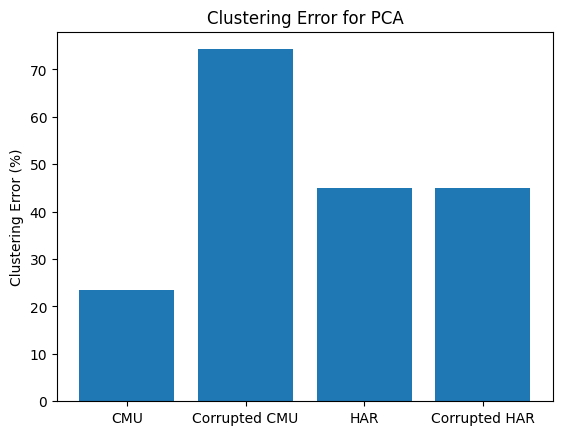

In [16]:
errors = [error_pca_cmu, error_pca_cmu_corrupted, error_pca_har, error_pca_har_corrupted]
datasets = ['CMU', 'Corrupted CMU', 'HAR', 'Corrupted HAR']
plt.bar(datasets, errors)
plt.ylabel('Clustering Error (%)')
plt.title('Clustering Error for PCA')
plt.show()

## Robust PCA

Clustering Error for CMU dataset: 21.25%


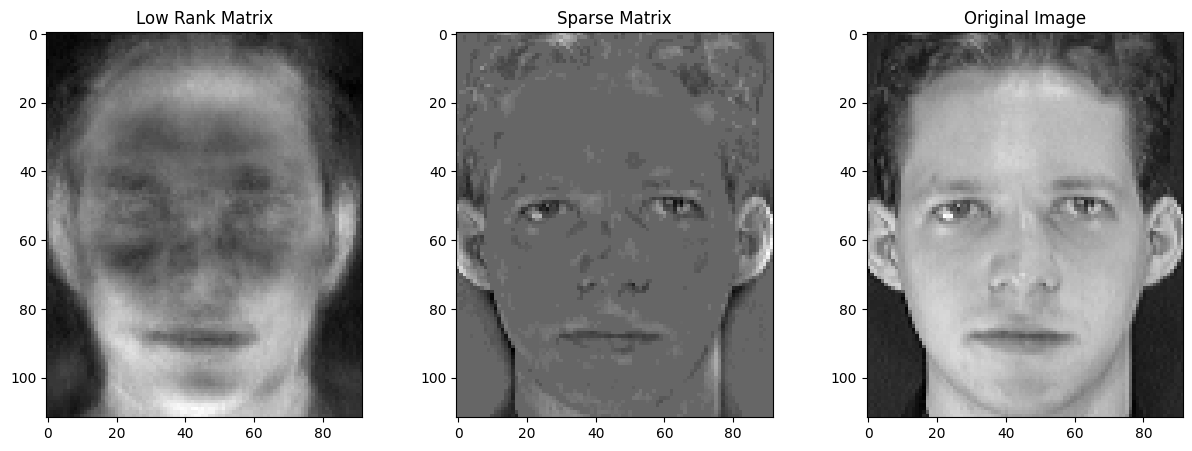

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cmu)
rpca = Robust_PCA(X_scaled)
L_cmu, S_cmu = rpca.fit()
error_rpca_cmu = rpca.pca_predict(y_cmu)
print(f'Clustering Error for CMU dataset: {error_rpca_cmu:.2f}%')

# plot sparse and low rank images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(L_cmu[0].reshape(112, 92), cmap='gray')
ax[0].set_title("Low Rank Matrix")
ax[1].imshow(S_cmu[0].reshape(112, 92), cmap='gray')
ax[1].set_title("Sparse Matrix")
ax[2].imshow(X_cmu[0].reshape(112, 92), cmap='gray')
ax[2].set_title("Original Image")
plt.show()

In [18]:
scaler = StandardScaler()
X_corrupted_scaled = scaler.fit_transform(X_cmu_corrupted)
rpca = Robust_PCA(X_corrupted_scaled)
L_cmu, S_cmu = rpca.fit()
error_rpca_cmu_corrupted = rpca.pca_predict(y_cmu_corrupted)
print(f'Clustering Error for Corrupted CMU dataset: {error_rpca_cmu_corrupted:.2f}%')

Clustering Error for Corrupted CMU dataset: 74.50%


In [19]:
rpca = Robust_PCA(df_har)
L_har, S_har = rpca.fit()
error_rpca_har = rpca.pca_predict(y_har)
print(f'Clustering Error for HAR dataset: {error_rpca_har:.2f}%')

Clustering Error for HAR dataset: 30.86%


In [20]:
rpca = Robust_PCA(df_har_missing_imputed)
X_har_missing_pca = rpca.fit()
error_rpca_har_corrupted = rpca.pca_predict(y_har)
print(f'Clustering Error for Corrupted HAR dataset: {error_rpca_har_corrupted:.2f}%')

Clustering Error for Corrupted HAR dataset: 24.27%


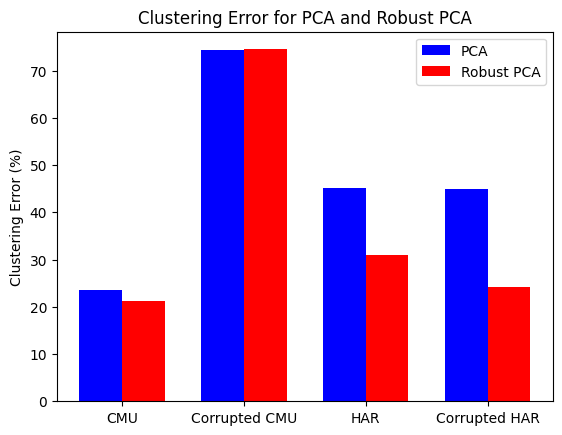

In [21]:
# Define the errors and datasets
errors_pca = [error_pca_cmu, error_pca_cmu_corrupted, error_pca_har, error_pca_har_corrupted]
errors_rpca = [error_rpca_cmu, error_rpca_cmu_corrupted, error_rpca_har, error_rpca_har_corrupted]
errors_pca_known = [16, 41]
errors_rpca_known = [5, 8]
errors_rpcaa_knwon = [1, 7]
datasets = ['CMU', 'Corrupted CMU', 'HAR', 'Corrupted HAR']

x = np.arange(len(datasets))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, errors_pca, width, label='PCA', color='blue')
bars2 = ax.bar(x + width/2, errors_rpca, width, label='Robust PCA', color='red')

ax.set_ylabel('Clustering Error (%)')
ax.set_title('Clustering Error for PCA and Robust PCA')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
plt.show()

## Robust PCA on Graphs

In [ ]:
gamma_values= [2**(-3), 2**(-2), 1/2, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000]
# errors_rpcaa_cmu = []
# scaler = StandardScaler()
# X_cmu_scaled = scaler.fit_transform(X_cmu)
# for gamma in gamma_values:
#     rpca = Robust_PCA_augmented(X_cmu, gamma=gamma)
#     L_cmu, S_cmu = rpca.fit()
#     error_rpcaa_cmu = rpca.pca_predict(y_cmu)
#     errors_rpcaa_cmu.append(error_rpcaa_cmu)
errors_rpcaa_cmu = [44.9, 34.0, 32.25, 81.0, 80.0, 78.75, 79.5, 51.24, 51.5, 42.0, 43.75, 42.75, 41.0]
error_rpcaa_cmu = np.min(errors_rpcaa_cmu)
rt = 14*60 + 8
print(f'Clustering Error for CMU dataset: {errors_rpcaa_cmu}')

Clustering Error for CMU dataset: [np.float64(44.99999999999999), np.float64(34.0), np.float64(32.25), np.float64(81.0), np.float64(80.0), np.float64(78.75), np.float64(79.5), np.float64(51.24999999999999), np.float64(51.5), np.float64(42.00000000000001), np.float64(43.75), np.float64(42.75), np.float64(41.0)]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cmu)
rpca = Robust_PCA_augmented(X_cmu, gamma=1/2)
L_cmu, S_cmu = rpca.fit()
error_rpca_cmu = rpca.pca_predict(y_cmu)
print(f'Clustering Error for CMU dataset: {error_rpca_cmu:.2f}%')

# plot sparse and low rank images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(L_cmu[0].reshape(112, 92), cmap='gray')
ax[0].set_title("Low Rank Matrix")
ax[1].imshow(S_cmu[0].reshape(112, 92), cmap='gray')
ax[1].set_title("Sparse Matrix")
ax[2].imshow(X_cmu[0].reshape(112, 92), cmap='gray')
ax[2].set_title("Original Image")
plt.show()

In [ ]:
errors_rpcaa_cmu_knn = []
scaler = StandardScaler()
X_cmu_scaled = scaler.fit_transform(X_cmu)
for gamma in gamma_values:
    rpca = Robust_PCA_augmented(X_cmu, gamma=gamma, knn=num_people_cmu)
    L_cmu, S_cmu = rpca.fit()
    error_rpcaa_cmu = rpca.pca_predict(y_cmu)
    errors_rpcaa_cmu_knn.append(error_rpcaa_cmu)
error_rpcaa_cmu_knn = np.min(errors_rpcaa_cmu_knn)
print(f'Clustering Error for CMU dataset: {errors_rpcaa_cmu_knn}')
# Clustering Error for CMU dataset: [np.float64(40.75), np.float64(32.75), np.float64(32.75), np.float64(80.5), np.float64(80.0), np.float64(78.75), np.float64(79.5), np.float64(52.0), np.float64(51.5), np.float64(43.50000000000001), np.float64(42.75), np.float64(42.25), np.float64(43.25)]

Clustering Error for CMU dataset: [np.float64(40.75), np.float64(32.75), np.float64(32.75), np.float64(80.5), np.float64(80.0), np.float64(78.75), np.float64(79.5), np.float64(52.0), np.float64(51.5), np.float64(43.50000000000001), np.float64(42.75), np.float64(42.25), np.float64(43.25)]


In [ ]:
scaler = StandardScaler()
X_corrupted_scaled = scaler.fit_transform(X_cmu_corrupted)
errors_rpcaa_cmu_corrupted = []
for gamma in gamma_values:
    rpca = Robust_PCA_augmented(X_corrupted_scaled, gamma=gamma)
    L_cmu, S_cmu = rpca.fit()
    error_rpcaa_cmu_corrupted = rpca.pca_predict(y_cmu_corrupted)
    errors_rpcaa_cmu_corrupted.append(error_rpcaa_cmu_corrupted)
error_rpcaa_cmu_corrupted = np.min(errors_rpcaa_cmu_corrupted)
print(f'Clustering Error for Corrupted CMU dataset: {errors_rpcaa_cmu_corrupted}%')
# Clustering Error for Corrupted CMU dataset: [np.float64(67.75), np.float64(68.25), np.float64(70.5), np.float64(78.75), np.float64(78.25), np.float64(79.0), np.float64(78.25), np.float64(77.5), np.float64(77.5), np.float64(76.5), np.float64(76.5), np.float64(76.25), np.float64(75.5)]%


Clustering Error for Corrupted CMU dataset: [np.float64(67.75), np.float64(68.25), np.float64(70.5), np.float64(78.75), np.float64(78.25), np.float64(79.0), np.float64(78.25), np.float64(77.5), np.float64(77.5), np.float64(76.5), np.float64(76.5), np.float64(76.25), np.float64(75.5)]%


In [ ]:
scaler = StandardScaler()
X_corrupted_scaled = scaler.fit_transform(X_cmu_corrupted)
errors_rpcaa_cmu_corrupted_knn = []
for gamma in gamma_values:
    rpca = Robust_PCA_augmented(X_corrupted_scaled, gamma=gamma, knn=num_people_corrupted)
    L_cmu, S_cmu = rpca.fit()
    error_rpcaa_cmu_corrupted = rpca.pca_predict(y_cmu_corrupted)
    errors_rpcaa_cmu_corrupted_knn.append(error_rpcaa_cmu_corrupted)
error_rpcaa_cmu_corrupted_knn = np.min(errors_rpcaa_cmu_corrupted_knn)
print(f'Clustering Error for Corrupted CMU dataset: {errors_rpcaa_cmu_corrupted_knn}%')
# Clustering Error for Corrupted CMU dataset: [np.float64(68.0), np.float64(67.0), np.float64(64.75), np.float64(78.75), np.float64(78.5), np.float64(79.5), np.float64(78.5), np.float64(78.5), np.float64(76.75), np.float64(76.25), np.float64(76.75), np.float64(76.0), np.float64(75.0)]%

Clustering Error for Corrupted CMU dataset: [np.float64(68.0), np.float64(67.0), np.float64(64.75), np.float64(78.75), np.float64(78.5), np.float64(79.5), np.float64(78.5), np.float64(78.5), np.float64(76.75), np.float64(76.25), np.float64(76.75), np.float64(76.0), np.float64(75.0)]%


In [ ]:
errors_rpcaa_har = []
for gamma in gamma_values:
    rpca = Robust_PCA_augmented(df_har, gamma=gamma)
    X_har_pca = rpca.fit()
    error_rpcaa_har = rpca.pca_predict(y_har)
    errors_rpcaa_har.append(error_rpcaa_har)
error_rpcaa_har = np.min(errors_rpcaa_har)
print(f'Clustering Error for HAR dataset: {errors_rpcaa_har}%')
#Clustering Error for HAR dataset: [np.float64(12.431991294885748), np.float64(20.212187159956475), np.float64(20.729053318824807), np.float64(30.50870511425462), np.float64(12.663220892274207), np.float64(12.690424374319909), np.float64(12.554406964091402), np.float64(22.130032644178456), np.float64(21.803590859630027), np.float64(24.931991294885748), np.float64(12.649619151251358), np.float64(20.429815016322085), np.float64(12.554406964091402)]%


c:\MVA\1er Semestre\G Data Analysis\RPCA\rpcaa\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\MVA\1er Semestre\G Data Analysis\RPCA\rpcaa\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\MVA\1er Semestre\G Data Analysis\RPCA\rpcaa\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=

Clustering Error for HAR dataset: [np.float64(12.431991294885748), np.float64(20.212187159956475), np.float64(20.729053318824807), np.float64(30.50870511425462), np.float64(12.663220892274207), np.float64(12.690424374319909), np.float64(12.554406964091402), np.float64(22.130032644178456), np.float64(21.803590859630027), np.float64(24.931991294885748), np.float64(12.649619151251358), np.float64(20.429815016322085), np.float64(12.554406964091402)]%


In [27]:
errors_rpcaa_har_knn = []
for gamma in gamma_values:
    rpca = Robust_PCA_augmented(df_har, gamma=gamma, knn=len(np.unique(y_har)))
    X_har_pca = rpca.fit()
    error_rpcaa_har = rpca.pca_predict(y_har)
    errors_rpcaa_har_knn.append(error_rpcaa_har)
error_rpcaa_har_knn = np.min(errors_rpcaa_har_knn)
print(f'Clustering Error for HAR dataset: {errors_rpcaa_har}%')

KeyboardInterrupt: 

In [ ]:
errors_rpcaa_har_corrupted = []
for gamma in gamma_values:
    rpca = Robust_PCA_augmented(df_har_missing_imputed, gamma=gamma)
    X_har_missing_pca = rpca.fit()
    error_rpcaa_har_corrupted = rpca.pca_predict(y_har)
    errors_rpcaa_har_corrupted.append(error_rpcaa_har_corrupted)
error_rpcaa_har_corrupted = np.min(errors_rpcaa_har_corrupted)
print(f'Clustering Error for Corrupted HAR dataset: {errors_rpcaa_har_corrupted}%')

In [ ]:
errors_rpcaa_har_corrupted_knn = []
for gamma in gamma_values:
    rpca = Robust_PCA_augmented(df_har_missing_imputed, gamma=gamma)
    X_har_missing_pca = rpca.fit()
    error_rpcaa_har_corrupted = rpca.pca_predict(y_har)
    errors_rpcaa_har_corrupted_knn.append(error_rpcaa_har_corrupted)
error_rpcaa_har_corrupted_knn = np.min(errors_rpcaa_har_corrupted_knn)
print(f'Clustering Error for Corrupted HAR dataset: {errors_rpcaa_har_corrupted_knn}%')

In [ ]:
errors_pca = [error_pca_cmu, error_pca_cmu_corrupted, error_pca_har, error_pca_har_corrupted]
errors_rpca = [error_rpca_cmu, error_rpca_cmu_corrupted, error_rpca_har, error_rpca_har_corrupted]
errors_rpcaa = [error_rpcaa_cmu, error_rpcaa_cmu_corrupted, error_rpcaa_har, error_rpcaa_har_corrupted]
errors_rpcaa_knn = [error_rpcaa_cmu_knn, error_rpcaa_cmu_corrupted_knn, error_rpcaa_har_knn, error_rpcaa_har_corrupted_knn]
datasets = ['CMU', 'Corrupted CMU', 'HAR', 'Corrupted HAR']

x = np.arange(len(datasets))

width = 0.2
fig, ax = plt.subplots()
bars1 = ax.bar(x - width, errors_pca, width, label='PCA', color='blue')
bars2 = ax.bar(x, errors_rpca, width, label='Robust PCA', color='red')
bars3 = ax.bar(x + width, errors_rpcaa, width, label='Robust PCA Augmented', color='green')
bars4 = ax.bar(x + 2*width, errors_rpcaa_knn, width, label='Robust PCA Augmented KNN', color='purple')

ax.set_ylabel('Clustering Error (%)')
ax.set_title('Clustering Error for PCA, Robust PCA, and Robust PCA Augmented with and without KNN')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

plt.show()